# Single-Shot CNN Denoising

We demonstrate that a deep neural net can be trained to denoise a _single_ noisy image, taking advantage of the fact that one 512 x 512 image contains ~250,000 dimensions of information.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import sys
sys.path.append("..")


In [3]:
from util import show, plot_images, plot_tensors

c:\Users\ADMIN\anaconda3\envs\0726_noise2self\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters import gaussian, median
from skimage import data, img_as_float, img_as_ubyte
from skimage.color import gray2rgb
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr


from skimage.io import imread, imshow_collection
from skimage import data
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
plt.rc('figure', figsize = (5,5))

(800, 800)
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [254 254 254 ... 247 246 246]
 [254 254 254 ... 247 246 245]
 [254 254 254 ... 247 246 245]]


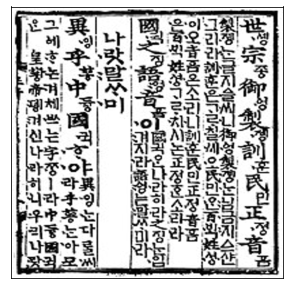

In [7]:
import cv2
from PIL import Image
#path = "D:/noise2self-master/noise2self-master/sar_data"
# 이미지 읽기
img_gray = cv2.imread("../sar_data/200px-Hunmin_jeong-eum.png")

# 컬러 이미지를 그레이스케일로 변환
img_cv_gray = cv2.cvtColor(img_gray, cv2.COLOR_BGR2GRAY)
show(img_cv_gray)
print(img_cv_gray.shape)
print(img_cv_gray)

# 이미지 저장
#cv2.imwrite(path, img_cv_gray)
#cv2.imwrite("D:/noise2self-master/noise2self-master/ddiirr", img_cv_gray)
# 이미지 사이즈 변경
# img_gray_resize = cv2.resize(img_cv_gray, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)  # 가로, 세로 모두 반으로 줄이기
# img_gray_reduced = cv2.resize(img_cv_gray, None, interpolation=cv2.INTER_AREA)

# 이미지 화면으로 보기
# cv2.imshow('color', img_gray)  # color라는 이름의 윈도우 안에 img_gray 이미지 보여주기
# cv2.imshow('gray-scale', img_gray_resize)
# cv2.imshow('gray-scale reduced', img_gray_reduced)



(800, 800)
[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [0.99607843 0.99607843 0.99607843 ... 0.96862745 0.96470588 0.96470588]
 [0.99607843 0.99607843 0.99607843 ... 0.96862745 0.96470588 0.96078431]
 [0.99607843 0.99607843 0.99607843 ... 0.96862745 0.96470588 0.96078431]]


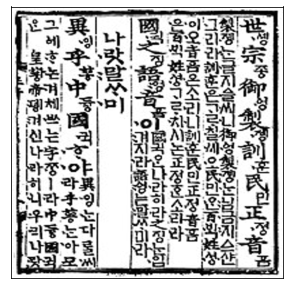

In [8]:

from skimage.transform import resize
img_resize = resize(img_cv_gray, (800,800))
show(img_resize)
print(img_resize.shape)
print(img_resize)


In [11]:
test_arr = np.array(img_resize)
print(test_arr)
print('\n\n', 1+test_arr*-1)
rs_arr = 1+test_arr*-1

[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [0.99607843 0.99607843 0.99607843 ... 0.96862745 0.96470588 0.96470588]
 [0.99607843 0.99607843 0.99607843 ... 0.96862745 0.96470588 0.96078431]
 [0.99607843 0.99607843 0.99607843 ... 0.96862745 0.96470588 0.96078431]]


 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00392157 0.00392157 0.00392157 ... 0.03137255 0.03529412 0.03529412]
 [0.00392157 0.00392157 0.00392157 ... 0.03137255 0.03529412 0.03921569]
 [0.00392157 0.00392157 0.00392157 ... 0.03137255 0.03529412 0.03921569]]


(800, 800)


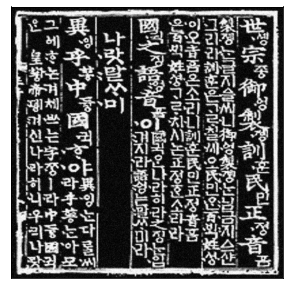

In [19]:
# np.random.seed(3)
# noisy_image = random_noise(img_resize, mode = 'gaussian', var=1)
noisy_image = random_noise(rs_arr, mode = 'gaussian')        # test 
show(noisy_image)
print(noisy_image.shape)

In [113]:
import torch
noisy = torch.Tensor(noisy_image[np.newaxis, np.newaxis])

In [114]:
noisy.shape

torch.Size([1, 1, 800, 800])

In [115]:
# ---- GPU
# from util import getbestgpu
# device = getbestgpu()

# Masking

The strategy is to train a $J$-invariant version of a neural net by replacing a grid of pixels with the average of their neighbors, then only evaluating the model on the masked pixels.

In [116]:
from mask import Masker
masker = Masker(width = 4, mode='interpolate')
# masker = Masker(width = 4, mode='zero')

# Model

For our model, we use a deep convolutional network.

In [117]:
torch.manual_seed(3)
from models.dncnn import DnCNN
model = DnCNN(1, num_of_layers = 5)

In [118]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

112128

In [119]:
noisy_image.ravel().shape

(640000,)

# Training

In [120]:
from torch.nn import MSELoss, L1Loss
from torch.optim import Adam

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.02)

In [121]:
# ------ GPU
# model = model.to(device)
# noisy = noisy.to(device)

In [122]:
losses = []
val_losses = []
best_images = []
best_val_loss = 1

for i in range(9000):
    model.train()
    
    net_input, mask = masker.mask(noisy, i % (masker.n_masks - 1))
    net_output = model(net_input)
    
    loss = loss_function(net_output*mask, noisy*mask)
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()
    
    if i % 10 == 0:
        losses.append(loss.item())
        model.eval()
        
        net_input, mask = masker.mask(noisy, masker.n_masks - 1)
        net_output = model(net_input)
    
        val_loss = loss_function(net_output*mask, noisy*mask)
        
        val_losses.append(val_loss.item())
        
        print("(", i, ") Loss: \t", round(loss.item(), 5), "\tVal Loss: \t", round(val_loss.item(), 5))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            denoised = np.clip(model(noisy).detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
            best_psnr = psnr(denoised, noisy_image)
            best_images.append(denoised)
            print("\tModel PSNR: ", np.round(best_psnr, 2))

( 0 ) Loss: 	 0.02682 	Val Loss: 	 0.01736
	Model PSNR:  5.83
( 10 ) Loss: 	 0.10837 	Val Loss: 	 0.12233
( 20 ) Loss: 	 0.01842 	Val Loss: 	 0.01717
	Model PSNR:  5.81
( 30 ) Loss: 	 0.01385 	Val Loss: 	 0.01611
	Model PSNR:  5.92
( 40 ) Loss: 	 0.01362 	Val Loss: 	 0.01378
	Model PSNR:  6.3
( 50 ) Loss: 	 0.01345 	Val Loss: 	 0.01352
	Model PSNR:  6.69
( 60 ) Loss: 	 0.01336 	Val Loss: 	 0.01341
	Model PSNR:  6.6
( 70 ) Loss: 	 0.01327 	Val Loss: 	 0.01327
	Model PSNR:  6.72
( 80 ) Loss: 	 0.01326 	Val Loss: 	 0.01327
	Model PSNR:  6.79
( 90 ) Loss: 	 0.01323 	Val Loss: 	 0.0132
	Model PSNR:  6.8
( 100 ) Loss: 	 0.01316 	Val Loss: 	 0.0132
( 110 ) Loss: 	 0.01317 	Val Loss: 	 0.01315
	Model PSNR:  6.87
( 120 ) Loss: 	 0.01316 	Val Loss: 	 0.01315
	Model PSNR:  6.89
( 130 ) Loss: 	 0.01309 	Val Loss: 	 0.01312
	Model PSNR:  6.91
( 140 ) Loss: 	 0.01313 	Val Loss: 	 0.01311
	Model PSNR:  6.93
( 150 ) Loss: 	 0.01313 	Val Loss: 	 0.0131
	Model PSNR:  6.94
( 160 ) Loss: 	 0.01307 	Val Lo

In [ ]:
import os 
path = r'..\sar_data/test2'.replace('\\', '/', 10)
plot_images(best_images)
plt.savefig(f'{path}/plot_images')


In [98]:
denoised = best_images[-1]

In [99]:
psnr(denoised, noisy_image)

6.044276606411759

In [100]:
inset_x_min = 10
inset_x_max = 170
inset_y_min = 90
inset_y_max = 220

get_inset = lambda x: x[inset_x_min:inset_x_max, inset_y_min:inset_y_max]

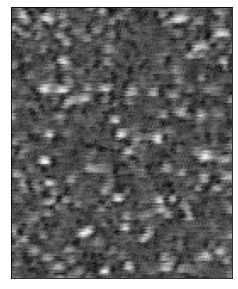

In [101]:
show(get_inset(denoised))
plt.savefig(f'{path}/enlarge')

In [102]:
inset_x_min = 10
inset_x_max = 600
inset_y_min = 10
inset_y_max = 600

get_inset = lambda x: x[inset_x_min:inset_x_max, inset_y_min:inset_y_max]

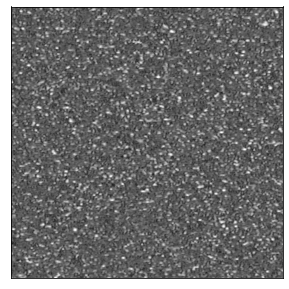

In [103]:
show(get_inset(denoised))
plt.savefig(f'{path}/best')

In [104]:
inset_x_min = 0
inset_x_max = 800
inset_y_min = 0
inset_y_max = 800

get_inset = lambda x: x[inset_x_min:inset_x_max, inset_y_min:inset_y_max]

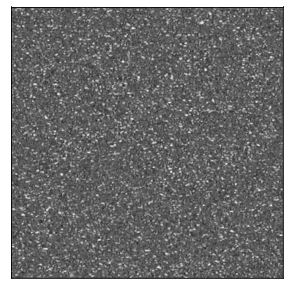

In [105]:
show(get_inset(denoised))
plt.savefig(f'{path}/best')